In [1]:
using Pkg
Pkg.activate("../../Project.toml")

include("../../LogLoss/RealRealHighDimension.jl")
include("../ForecastingMainNew.jl");
using JLD2
using DataFrames
using StatProfilerHTML
using BenchmarkTools

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


In [9]:
svpath_ns = "../../Data/ecg200/mps_saves/legendre_no_norm10_ns_d20_chi100.jld2" #legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"
svpath_gd = "../../Data/ecg200/mps_saves/legendre_no_normGD_10_ns_d20_chi100.jld2"
dloc =  "../../Data/ecg200/datasets/ecg200.jld2"



f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)



###################################3

f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)

opts_ns, _... = safe_options(opts_ns, nothing, nothing)

fc_ns = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

#####################################################

f = jldopen(svpath_ns, "r")
    mps_gd = read(f, "mps")
    opts_gd = read(f, "opts")
close(f)

opts_gd, _... = safe_options(opts_gd, nothing, nothing)

fc_gd = load_forecasting_info_variables(mps_gd, X_train, y_train, X_test, y_test, opts_gd);


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


In [10]:
Xs = [X_train; X_test]
ys = [y_train; y_test]
train_ratio = length(y_train)/length(ys)
num_resamps = 29
splits = [
    if i == 0
        (collect(1:length(y_train)), collect(length(y_train)+1:length(ys)))   
    else
        MLJ.partition(1:length(ys), train_ratio, rng=MersenneTwister(i), stratify=ys) 
    end 
    for i in 0:num_resamps]


30-element Vector{Tuple{Vector{Int64}, Vector{Int64}}}:
 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [101, 102, 103, 104, 105, 106, 107, 108, 109, 110  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200])
 ([192, 166, 169, 89, 15, 165, 111, 174, 191, 164  …  13, 154, 11, 138, 27, 93, 180, 54, 104, 131], [126, 117, 81, 98, 24, 80, 125, 16, 105, 157  …  79, 120, 29, 171, 101, 83, 188, 195, 194, 175])
 ([179, 185, 48, 65, 3, 2, 63, 69, 128, 13  …  37, 49, 98, 36, 47, 171, 34, 103, 146, 127], [164, 107, 173, 108, 35, 91, 168, 70, 112, 50  …  141, 145, 161, 151, 82, 11, 124, 102, 14, 181])
 ([150, 43, 11, 135, 35, 57, 98, 104, 197, 84  …  4, 121, 33, 90, 166, 52, 149, 66, 36, 16], [167, 153, 29, 183, 17, 143, 172, 138, 81, 56  …  80, 78, 117, 60, 24, 97, 113, 53, 48, 106])
 ([68, 109, 12, 27, 82, 76, 184, 126, 170, 188  …  198, 186, 139, 171, 156, 114, 51, 60, 103, 116], [45, 180, 3, 110, 10, 52, 148, 6, 55, 199  …  84, 44, 127, 117, 95, 48, 193, 17, 94, 1

In [12]:
inds_tr, inds_te = splits[2]
X_train2, X_test2 = Xs[inds_tr, :], Xs[inds_te, :]
y_train2, y_test2 = ys[inds_tr], ys[inds_te]
fc_nn = load_forecasting_info_variables(mps_gd, X_train2, y_train2, X_test2, y_test2, opts_gd);

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


In [15]:
mode_range=(-1,1)
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts_ns.d)
xvals_enc= [get_state(x, opts_ns) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];

In [16]:
include("../ForecastingMainNew.jl");


╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.359418 │
╰────────┴──────────╯


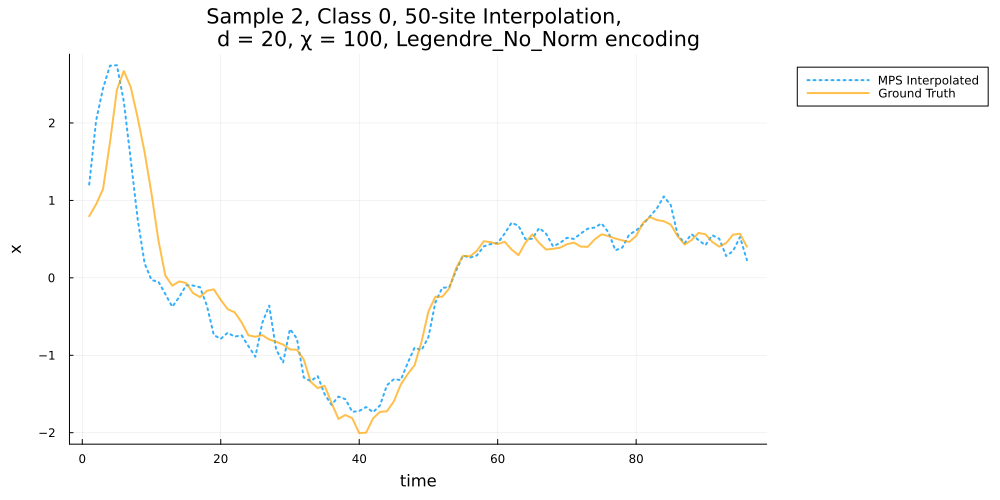

In [17]:

max_jump=0.5
class = 0
interp_sites = collect(1:50)
instance_idx = 2 # 4
invert_transform=true
stats, p1_ns = any_interpolate_single_timeseries(fc_gd, class, instance_idx, interp_sites, :nearestNeighbour; invert_transform=invert_transform, NN_baseline=false, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);


pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

In [35]:


mode_range=(-1,1)
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts_ns.d)
xvals_enc= [get_state(x, opts_ns) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];


max_jump=1

stats = []
for sp in splits
    inds_tr, inds_te = sp
    X_train2, X_test2 = Xs[inds_tr, :], Xs[inds_te, :]
    y_train2, y_test2 = ys[inds_tr], ys[inds_te]

    n1s = sum(y_test2)
    n0s = length(y_test2) - n1s


    mode_range=(-1,1)
    xvals=collect(range(mode_range...; step=1E-4))
    mode_index=Index(opts_ns.d)
    xvals_enc= [get_state(x, opts_ns) for x in xvals]
    xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];
    
    
    max_jump=1
    
    stats = []
    for sp in splits
        inds_tr, inds_te = sp
        X_train2, X_test2 = Xs[inds_tr, :], Xs[inds_te, :]
        y_train2, y_test2 = ys[inds_tr], ys[inds_te]
    
        n1s = sum(y_test2)
        n0s = length(y_test2) - n1s
    
        samples = [1:n0s; 1:n1s]
        classes = [zeros(Int,n0s); ones(Int,n1s)]
        fc_nn = load_forecasting_info_variables(mps_gd, X_train2, y_train2, X_test2, y_test2, opts_gd);
        ps1 = []
        ps2 = []
        stats1 = []
        for (i,s) in enumerate(samples)
            class = classes[i]
            instance_idx = s
            stat1, p1 = any_interpolate_single_timeseries(fc_nn, class, instance_idx, interp_sites, :nearestNeighbour; invert_transform=invert_transform, NN_baseline=false, X_train=X_train2, y_train=y_train2, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);
            # push!(ps1, p1...)
            push!(stats1, stat1)
        end
    
        push!(stats, stats1)
    end
    
    samples = [1:n0s; 1:n1s]
    classes = [zeros(Int,n0s); ones(Int,n1s)]
    fc_nn = load_forecasting_info_variables(mps_gd, X_train2, y_train2, X_test2, y_test2, opts_gd);
    ps1 = []
    ps2 = []
    stats1 = []
    for (i,s) in enumerate(samples)
        class = classes[i]
        instance_idx = s
        stat1, p1 = any_interpolate_single_timeseries(fc_nn, class, instance_idx, interp_sites, :nearestNeighbour; invert_transform=invert_transform, NN_baseline=false, X_train=X_train2, y_train=y_train2, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);
        # push!(ps1, p1...)
        push!(stats1, stat1)
    end

    push!(stats, stats1)
end


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:542
┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:542


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:542
┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:542


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:542



 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534


In [36]:
means = Vector{Float64}(undef, length(stats))
meds= Vector{Float64}(undef, length(stats))

for (i,stat) in enumerate(stats)
    df = vcat(DataFrame.(stat)...)

    means[i] = (df |> describe)[!,2][1]
    meds[i] = (df |> describe)[!,4][1]
end


In [37]:
means |> mean

0.3421652508418289

In [38]:
meds |> median

0.27191348978289476

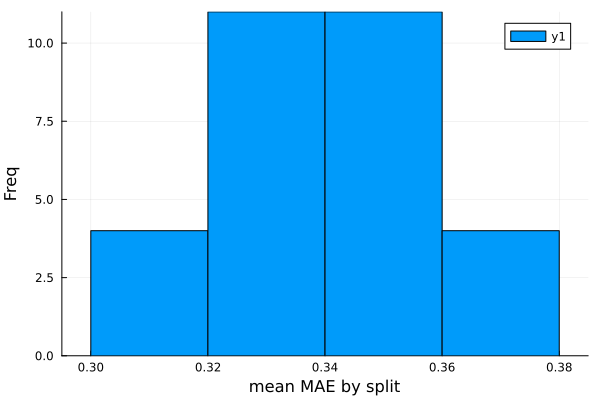

In [47]:
histogram(means, ylabel="Freq", xlabel="mean MAE by split")

In [61]:


mode_range=(-1,1)
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts_ns.d)
xvals_enc= [get_state(x, opts_ns) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];

nsites = size(X_train2,2)
nendpoints = 0:floor(Int, nsites/2)-1

max_jump=1

stats = []
for sp in [splits[1]]
    inds_tr, inds_te = sp
    X_train2, X_test2 = Xs[inds_tr, :], Xs[inds_te, :]
    y_train2, y_test2 = ys[inds_tr], ys[inds_te]

    n1s = sum(y_test2)
    n0s = length(y_test2) - n1s

    samples = [1:n0s; 1:n1s]
    classes = [zeros(Int,n0s); ones(Int,n1s)]
    fc_nn = load_forecasting_info_variables(mps_gd, X_train2, y_train2, X_test2, y_test2, opts_gd);

    for n in nendpoints
        interp_sites = 1+n:nsites-n |> collect
        stats1 = []
        for (i,s) in enumerate(samples)
            class = classes[i]
            instance_idx = s
            stat1, p1 = any_interpolate_single_timeseries(fc_nn, class, instance_idx, interp_sites, :nearestNeighbour; invert_transform=invert_transform, NN_baseline=false, X_train=X_train2, y_train=y_train2, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);
            # push!(ps1, p1...)
            push!(stats1, stat1)
        end
    
        push!(stats, stats1)
    end
end


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value more than 1% below lower bound after train normalization!
└ @ Main /home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:534
┌ Warning: Test set has a value mor

In [63]:
for n in nendpoints
    @show interp_sites = 1+n:nsites-n |> collect
end

interp_sites = 1 + n:nsites - n |> collect = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
interp_sites = 1 + n:nsites - n |> collect = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
interp_sites = 1 + n:nsites - n |> collect = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34

In [64]:
stats

48-element Vector{Any}:
 Any[Dict(:MAE => 0.5266633557083334), Dict(:MAE => 0.2766113431979166), Dict(:MAE => 1.0135457446770832), Dict(:MAE => 0.9080176268821872), Dict(:MAE => 0.3509203028958334), Dict(:MAE => 0.8640908033302087), Dict(:MAE => 0.9462150877083332), Dict(:MAE => 1.2160916541791669), Dict(:MAE => 0.1687705332104166), Dict(:MAE => 1.0246269887187498)  …  Dict(:MAE => 0.8244069993395833), Dict(:MAE => 0.9286171336354162), Dict(:MAE => 0.7994054689184374), Dict(:MAE => 0.7444416942416665), Dict(:MAE => 1.2787154597812498), Dict(:MAE => 0.8121727615416666), Dict(:MAE => 1.13091848028125), Dict(:MAE => 0.8179057275312501), Dict(:MAE => 0.7883842744791667), Dict(:MAE => 1.0652489357687502)]
 Any[Dict(:MAE => 0.7267876475744681), Dict(:MAE => 0.16716224669148935), Dict(:MAE => 0.3052845914446809), Dict(:MAE => 0.5385058309435106), Dict(:MAE => 0.8064452207234041), Dict(:MAE => 0.7862951791202126), Dict(:MAE => 1.0894027991382977), Dict(:MAE => 1.0215220338425532), Dict(:MAE =>

In [65]:
means = Vector{Float64}(undef, length(stats))
meds= Vector{Float64}(undef, length(stats))

for (i,stat) in enumerate(stats)
    df = vcat(DataFrame.(stat)...)

    means[i] = (df |> describe)[!,2][1]
    meds[i] = (df |> describe)[!,4][1]
end

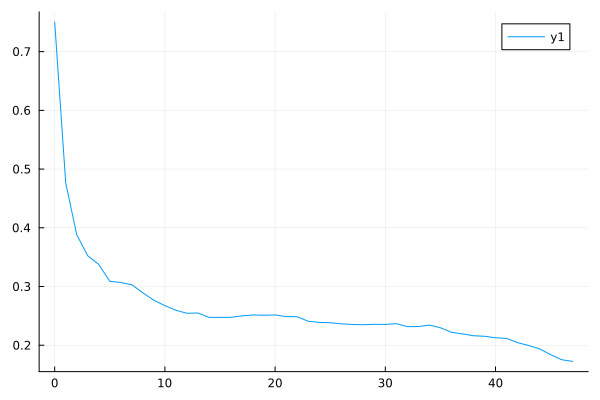

In [68]:
plot(nendpoints, means)

In [80]:
svpath = "MeanMode_GD_d20chi100_fitpersite.jld2"
f = jldopen(svpath, "r")
    stats = f["stats"]
    nendpoints = f["nendpoints"]
close(f)



In [81]:
df = vcat(DataFrame.(stats[26])...)


Row,MAE
,Float64
1,0.213252
2,0.165451
3,0.337813
4,0.488879
5,0.322642
6,0.819015
7,0.257345
8,0.583387
9,0.138353


In [83]:
means = Vector{Float64}(undef, length(stats))
meds= Vector{Float64}(undef, length(stats))

for (i,stat) in enumerate(stats)
    df = vcat(DataFrame.(stat)...)
    means[i] = (df |> describe)[!,2][1]
    meds[i] = (df |> describe)[!,4][1]
end

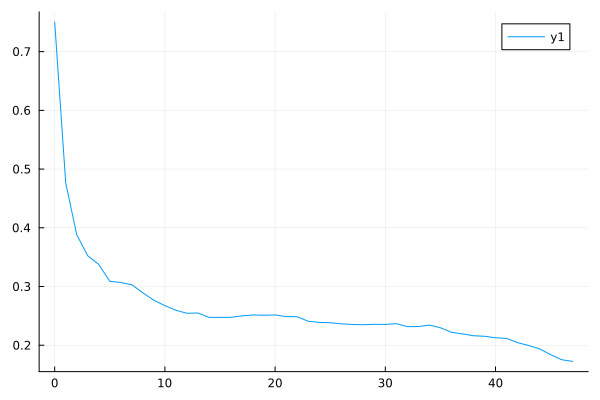

In [84]:
plot(nendpoints, means)

In [ ]:


mode_range=(-1,1)
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts_ns.d)
xvals_enc= [get_state(x, opts_ns) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];

nsites = size(X_train2,2)
nendpoints = 0:floor(Int, nsites/2)-1

max_jump=1

stats = []
for sp in [splits[1]]
    inds_tr, inds_te = sp
    X_train2, X_test2 = Xs[inds_tr, :], Xs[inds_te, :]
    y_train2, y_test2 = ys[inds_tr], ys[inds_te]

    n1s = sum(y_test2)
    n0s = length(y_test2) - n1s

    samples = [1:n0s; 1:n1s]
    classes = [zeros(Int,n0s); ones(Int,n1s)]
    fc_nn = load_forecasting_info_variables(mps_gd, X_train2, y_train2, X_test2, y_test2, opts_gd);

    for n in nendpoints
        interp_sites = 1+n:nsites-n |> collect
        stats1 = []
        for (i,s) in enumerate(samples)
            class = classes[i]
            instance_idx = s
            stat1, p1 = any_interpolate_single_timeseries(fc_nn, class, instance_idx, interp_sites, :MeanMode; invert_transform=invert_transform, NN_baseline=false, X_train=X_train2, y_train=y_train2, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);
            # push!(ps1, p1...)
            push!(stats1, stat1)
        end
    
        push!(stats, stats1)
    end
end
